# Accelerate ResNet18 model with TensorRT on NVIDIA Jetson

Deep learning models, especially convolutional neural networks (CNNs) like ResNet18, are widely used for image classification tasks. However, deploying these models on edge devices such as the NVIDIA Jetson platform requires optimization for efficiency and speed. TensorRT, NVIDIA’s high-performance deep learning inference library, provides a way to accelerate these models by optimizing them for Jetson’s GPU and Tensor Cores.

In this tutorial, we will fine-tune a ResNet18 model using PyTorch and accelerate its inference with TensorRT on [NVIDIA® Jetson Orin Nano™ Developer Kit](https://developer.nvidia.com/embedded/learn/jetson-orin-nano-devkit-user-guide/index.html). We will evaluate performance improvements by measuring inference speed on the Imagenette dataset, a smaller subset of ImageNet designed for rapid experimentation. Basic software and package versions include:

- **JetPack** - 6.2 (also compatible with 6.1)  
- **CUDA** - 12.6  
- **Python** - 3.10  
- **cuSPARSELt** - 0.7.0  

## Fine-tuning ResNet18 model to Imagenette

Follow NVIDIA official instructions for [flashing Jetson Orin Nano with JetPack 6.2](https://developer.nvidia.com/embedded/jetpack-sdk-62) and installing [PyTorch](https://forums.developer.nvidia.com/t/pytorch-for-jetson/72048). You can also refer to our detailed guide on installing these packages on Jetson device.

Unlike our previous guide, we will use pure PyTorch instead of `fastai` to fine-tune a pretrained ResNet18 model to Imagenette2-320 dataset. This dataset contains 10 categories (labels) compared to the original 1000 output classes in ImageNet, making it a great choice for benchmarking and rapid prototyping. Fine-tuning a pretrained ResNet18 model on Imagenette allows us to leverage the model’s existing feature representations while adapting it to a smaller, domain-specific dataset.

In [ ]:
#| eval: false
import os
import matplotlib.pyplot as plt
import tarfile
import time
import torch
import urllib.request

from pathlib import Path
from torchvision import datasets, transforms
from torchvision import models
from torchvision import utils as vutils
from tqdm import tqdm

### Prepare Imagenette dataset

To train our ResNet18 model on Imagenette, we first need to download and extract the dataset. The fastai library provides a convenient link to the dataset, which we can use to retrieve it directly.

In [ ]:
#| eval: false
# Check if the dataset has already been downloaded; if not, download and extract it
# Define the URL for Imagenette-320 dataset and the path where it should be saved
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"
data_dir = Path.cwd() / 'data'  # Use current working directory for data storage
dataset_path = data_dir / "imagenette2-320"

# Check if the dataset has already been downloaded; if not, download and extract it
if not dataset_path.exists():
    data_dir.mkdir(parents=True, exist_ok=True)
    
    # Download the dataset
    tar_path = data_dir / "imagenette2-320.tgz"
    urllib.request.urlretrieve(dataset_url, tar_path)
    
    # Extract the tar.gz file
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=data_dir)
    
    # Remove the tar.gz file after extraction
    os.remove(tar_path)

[ child for child in dataset_path.iterdir() ]

[PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/noisy_imagenette.csv'),
 PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/val'),
 PosixPath('/home/jetson/jetson-examples/tensorrt/data/imagenette2-320/train')]

Imagenette2-320 is available as a structured directory of images. We use `torchvision.datasets.ImageFolder` to load the dataset, applying standard image preprocessing and data augmentation using `torchvision.transforms`.

Training samples: 9469
Validation samples: 3925
Number of classes: 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


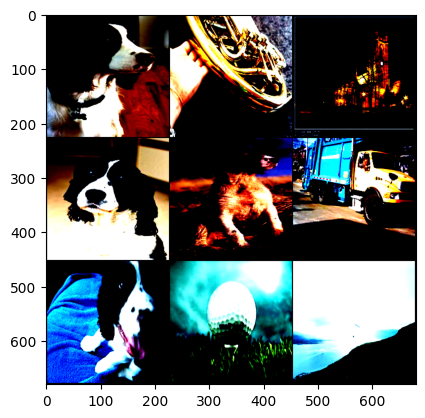

In [ ]:
#| eval: false
# Define the image transformations (resize and normalize)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize all images to 224x224 (height, width)
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip to some images
    transforms.ToTensor(),              # Convert images to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]),     # Normalize with ImageNet stats
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),              
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]),    
])

# Load the training and validation datasets
train_dataset = datasets.ImageFolder(root=dataset_path / 'train', transform=train_transform)
val_dataset = datasets.ImageFolder(root=dataset_path / 'val', transform=val_transform)

# Create data loaders for training and validation datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Check the number of images in the training and validation sets
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Check the number of classes in the dataset
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Display a batch of images
def show_batch(loader):
    # Get one batch of images
    images, labels = next(iter(loader))
    # Convert the batch of images to a grid of images
    grid = vutils.make_grid(images[:9], nrow=3)
    # Plot the grid of images
    plt.imshow(grid.permute(1, 2, 0).numpy())  # Permute to (H, W, C) for matplotlib
    plt.show()

# Show a batch from the training set
show_batch(train_loader)

### Fine-tune pretrained model

To prepare the model, we will first load a pretrained ResNet18 model from PyTorch's `torchvision` library, and then set up the model for training on the appropriate device (either GPU or CPU).

In [ ]:
#| eval: false
# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model set to device: {device}")

Model set to device: cuda


Next, we set up some additional utilities for training and validating the model, including:

- class `Recorder`: save training / validating durations, losses, and accuracy values in each epoch.  
- `train`: Custom function to train the model using One-Cycle learning rate policy.  
- `validate`: Custom function to validate the model.

In [ ]:
#| eval: false
class Recorder:
    """A class to record the training and validation metrics"""
    def __init__(self):
        self.durations = []
        self.losses = []
        self.accuracies = []

    def append(self, duration, loss, accuracy):
        self.durations.append(duration)
        self.losses.append(loss)
        self.accuracies.append(accuracy)

In [ ]:
#| eval: false
def train(model, train_loader, criterion, optimizer, epochs, lr_max, pct_start, div, device, recorder=None):
    """Train the model using a One-Cycle learning rate policy."""
    # Prepare the OneCycleLR scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=lr_max, 
        total_steps=len(train_loader)*epochs, 
        pct_start=pct_start, 
        div_factor=div)

    model.train()
    for epoch in range(epochs):
        # Initialize variables to track the loss and accuracy
        running_loss = 0.0
        running_corrects = 0
        start_time = time.time()

        # Progress bar for the training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        # Iterate over the training dataset
        for inputs, labels in progress_bar:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Compute the loss and accuracy
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        # Record the training metrics
        epoch_time = time.time() - start_time
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        if recorder:
            # Append the metrics to the Recorder object
            recorder.append(epoch_time, epoch_loss, epoch_acc)

        # Display the training metrics
        print(f"Epoch {epoch+1}/{epochs}, Duration: {epoch_time:.0f}s, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [ ]:
#| eval: false
def validate(model, val_loader, criterion, device, recorder=None):
    """Validate the model and return loss and accuracy."""
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track the loss, accuracy, and duration
    running_loss = 0.0
    running_corrects = 0
    start_time = time.time()
    
    # Progress bar for the validation loop
    progress_bar = tqdm(val_loader, desc="Validating", leave=False)
    
    # Disable gradient computation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            progress_bar.set_postfix(loss=loss.item())
    
    # Record the validation metrics
    val_time = time.time() - start_time
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)
    if recorder:
        recorder.append(val_time, val_loss, val_acc)
    
    print(f"Validation, Duration: {val_time:.0f}s, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    return val_loss, val_acc  # Return the loss and accuracy

The fine-tuning process for a pretrained model, like ResNet18, is typically done in two phases to effectively adapt the model to a new dataset. These phases are:

#### Phase 1: Train the Last Layer Only
In the first phase, we focus on training only the newly added fully connected (FC) layer, while freezing all other layers of the pretrained model. This helps the model quickly adapt to the new dataset without altering the general feature representations learned from ImageNet.

- **Freeze Pretrained Layers**: We freeze all layers except for the final FC layer so that their weights are not updated during training.  
- **Modify the Final Layer**: The final FC layer is replaced to match the number of classes in the new dataset (e.g., 10 classes for Imagenette).  
- **Set Up the Optimizer**: The optimizer is set up to update only the parameters of the new FC layer, with a suitable learning rate (base_lr).  
- **Train the New Head**: The model is trained for a few epochs (e.g., 1 epoch) to fine-tune just the final layer. This allows the model to adjust the classifier to the new dataset without altering the feature extractor.  

In [ ]:
#| eval: false
# Set up parameters for fine-tuning
epochs=3            # Number of epochs to train the whole model
freeze_epochs=1     # Number of epochs to train the last layer only
base_lr=2e-3        # Base learning rate
lr_mult=100         # Multiplier for the last layer's learning rate
pct_start=0.3       # Percentage of epochs to increase the learning rate
div=5.0             # Factor to divide the learning rate at the end of the one

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
#| eval: false
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer of the model
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.fc.parameters(), lr=base_lr)

# Train the model with the new head
print(f"Training the last layer only for {freeze_epochs} epochs...")
train(model, train_loader, criterion, optimizer, freeze_epochs, base_lr, pct_start, div, device)

Training the last layer only for 1 epochs...


Epoch 1/1, Duration: 109s, Loss: 0.5235, Accuracy: 0.8792


#### Phase 2: Fine-tune the Entire Model
In the second phase, we unfreeze all layers of the pretrained model, including the feature extractor, and train the entire network on the new dataset. This allows the model to fine-tune not only the classifier but also the feature extraction layers, adapting more specifically to the new dataset.

- **Unfreeze All Layers**: After training the classifier, all layers of the model are unfrozen, allowing their weights to be updated during training.
- **Adjust Optimizer**: A new optimizer is set up, typically with a lower learning rate for fine-tuning (often scaled by a factor, like lr_mult).
- **Train the Full Model**: The model is then trained for several more epochs (e.g., 3 epochs) to fine-tune the entire network on the new dataset. This helps the model adapt the low- and high-level features to the new task.

In [ ]:
#| eval: false
# Unfreeze all the layers
for param in model.parameters():
    param.requires_grad = True

# Adam optimizer for full model
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr/lr_mult)

# Train the full model
print(f"Fine-tuning the full model for {epochs} epochs...")
train_recorder = Recorder()
train(model, train_loader, criterion, optimizer, epochs, base_lr, pct_start, div, device, train_recorder)

Fine-tuning the full model for 3 epochs...


Epoch 1/3:   0%|                                        | 0/148 [00:00<?, ?it/s]

Epoch 1/3, Duration: 115s, Loss: 0.5454, Accuracy: 0.8372


Epoch 2/3, Duration: 114s, Loss: 0.4305, Accuracy: 0.8687


Epoch 3/3, Duration: 113s, Loss: 0.1415, Accuracy: 0.9559


Lastly, evaluate model performance on the validation dataset:

In [ ]:
#| eval: false
print("Validating the model...")
val_recorder = Recorder()
validate(model, val_loader, criterion, device, val_recorder)

Validating the model...


Validation, Duration: 48s, Loss: 0.2068, Accuracy: 0.9332


(0.2067526589381467, tensor(0.9332, device='cuda:0', dtype=torch.float64))

Save model to use in different sessions:

In [ ]:
#| eval: false
model.eval()

# Create 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model to a file
model_path = Path.cwd() / 'models' / 'resnet18_imagenette.pth'
torch.save(model.state_dict(), model_path)

## Acceleration with Torch-TensorRT

https://pytorch.org/TensorRT/getting_started/jetpack.html

In [ ]:
#| eval: false
import time
import torch
import torch_tensorrt
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm

In [ ]:
#| eval: false
def get_validation_loader(dataset_path, batch_size=16):
    """Load the validation dataset and return a DataLoader."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_dataset = datasets.ImageFolder((dataset_path / 'val'), transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return val_loader

In [ ]:
#| eval: false
# Load the model
def load_model(
        model_path, 
        device = 'cuda',  # Use 'cuda' if GPU is available, else use 'cpu'
        num_classes = 10,  # Number of classes in the dataset imagenette2-320
        use_fp16 = False,  # Use FP16 precision for TensorRT
):
    """Load the model from the specified path and set it to evaluation mode."""
    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    if use_fp16:
        model = model.half()
    model.to(device).eval()
    return model

In [ ]:
#| eval: false
def optimize_model_tensorrt(model, use_fp16=False, device='cuda:0'):
    """Optimize the model with TensorRT in either FP32 or FP16"""
    compile_spec = {
        "inputs": [
            torch_tensorrt.Input(
                min_shape=(1, 3, 224, 224),
                opt_shape=(8, 3, 224, 224),
                max_shape=(64, 3, 224, 224),
                dtype=torch.half if use_fp16 else torch.float
            )
        ],
        "enabled_precisions": {torch.half if use_fp16 else torch.float},
        "ir": "dynamo"
    }
    return torch_tensorrt.compile(model, **compile_spec, device=torch.device(device))

In [ ]:
#| eval: false
def evaluate_model(model, dataloader, device, use_fp16=False):
    """Evaluate accuracy & inference time for a given batch size"""
    total_time = 0.0
    running_corrects = 0

    progress_bar = tqdm(dataloader, desc="Evaluating performance...", leave=False)
    
    for inputs, labels in progress_bar:
            if use_fp16:
                inputs = inputs.half()
        
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            start_time = time.time()
            outputs = model(inputs)
            total_time += time.time() - start_time
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    inf_acc = float(running_corrects.double() / len(dataloader.dataset))
    avg_time = total_time / len(dataloader.dataset)

    return inf_acc, total_time, avg_time

In [ ]:
#| eval: false
# Build different models with optimizations for comparison
model_path = Path.cwd() / 'models' / 'resnet18_imagenette.pth'
baseline_model = load_model(model_path, use_fp16=False)
baseline_fp16_model = load_model(model_path, use_fp16=True)

start_time = time.time()  # Start time for compiling the models
trt_fp32_model = optimize_model_tensorrt(baseline_model, use_fp16=False)
print(f"FP32 model compiled in {time.time() - start_time:.2f} seconds")

start_time = time.time()
trt_fp16_model = optimize_model_tensorrt(baseline_fp16_model, use_fp16=True)
print(f"FP16 model compiled in {time.time() - start_time:.2f} seconds")

  model.load_state_dict(torch.load(model_path))



FP32 model compiled in 18.10 seconds


FP16 model compiled in 50.01 seconds


In [ ]:
#| eval: false
# Initialize inference
results = []
batch_sizes = [1, 8, 16, 32, 64]
dataset_path = Path.cwd() / 'data' / 'imagenette2-320'

for batch_size in batch_sizes:
    # Load validation dataset for each batch size
    val_loader = get_validation_loader(dataset_path, batch_size=batch_size)

    # Evaluate different models
    print(f"Evaluating models with batch size {batch_size}...")
    baseline_acc, baseline_total_time, baseline_avg_time = evaluate_model(baseline_model, val_loader, device, use_fp16=False)
    results.append([batch_size, "Baseline", baseline_acc, baseline_total_time, baseline_avg_time])
    trt_fp32_acc, trt_fp32_total_time, trt_fp32_avg_time = evaluate_model(trt_fp32_model, val_loader, device, use_fp16=False)
    results.append([batch_size, "TensorRT FP32", trt_fp32_acc, trt_fp32_total_time, trt_fp32_avg_time])
    baseline_fp16_acc, baseline_fp16_total_time, baseline_fp16_avg_time = evaluate_model(baseline_fp16_model, val_loader, device, use_fp16=True)
    results.append([batch_size, "Baseline FP16", baseline_fp16_acc, baseline_fp16_total_time, baseline_fp16_avg_time])
    trt_fp16_acc, trt_fp16_total_time, trt_fp16_avg_time = evaluate_model(trt_fp16_model, val_loader, device, use_fp16=True)
    results.append([batch_size, "TensorRT FP16", trt_fp16_acc, trt_fp16_total_time, trt_fp16_avg_time])

df_results = pd.DataFrame(results, columns=["Batch Size", "Model", "Accuracy", "Total Time", "Average Time"])
df_results

Evaluating models with batch size 1...


Evaluating models with batch size 8...


Evaluating models with batch size 16...


Evaluating models with batch size 32...


Evaluating models with batch size 64...


,Batch Size,Model,Accuracy,Total Time,Average Time
0,1,Baseline,0.929682,43.348487,0.011044
1,1,TensorRT FP32,0.929682,8.231340,0.002097
2,1,Baseline FP16,0.929682,48.804268,0.012434
3,1,TensorRT FP16,0.929682,17.782847,0.004531
4,8,Baseline,0.929682,6.542611,0.001667
5,8,TensorRT FP32,0.929682,2.076011,0.000529
6,8,Baseline FP16,0.929682,7.189516,0.001832
7,8,TensorRT FP16,0.929682,3.168359,0.000807
8,16,Baseline,0.929682,3.964534,0.001010
9,16,TensorRT FP32,0.929682,1.630216,0.000415


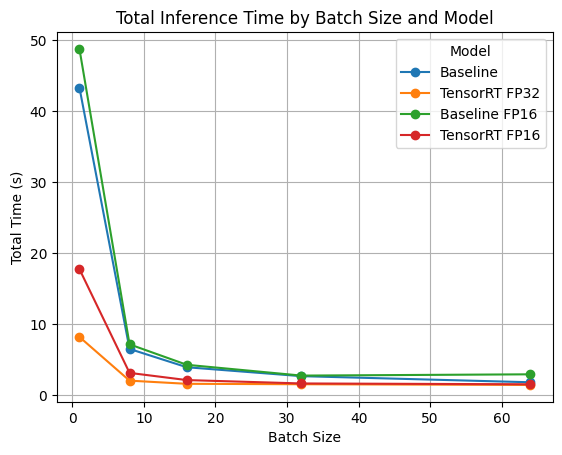

In [ ]:
#| eval: false
# Get unique models
models = df_results["Model"].unique()

# Line Plot for Total Inference Time by Batch Size
for model in models:
    subset = df_results[df_results["Model"] == model]
    plt.plot(subset["Batch Size"], subset["Total Time"], marker='o', linestyle='-', label=model)

plt.title("Total Inference Time by Batch Size and Model")
plt.ylabel("Total Time (s)")
plt.xlabel("Batch Size")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [ ]:
#| eval: false
# Compute Speed-up by TensorRT Compilation (same precision)
speedup_data = []
for baseline_name in ["Baseline", "Baseline FP16"]:
    for batch_size in df_results["Batch Size"].unique():
        precision = "FP16" if baseline_name == "Baseline FP16" else "FP32"
        baseline_time = df_results[(df_results["Batch Size"] == batch_size) & (df_results["Model"] == baseline_name)]["Total Time"].values
        tensorrt_time = df_results[(df_results["Batch Size"] == batch_size) & (df_results["Model"] == f"TensorRT {precision}")]["Total Time"].values
        if len(baseline_time) > 0 and len(tensorrt_time) > 0:
            speedup = baseline_time[0] / tensorrt_time[0]
            speedup_data.append({"Batch Size": batch_size, "Precision": precision, "Speed-up": speedup})

speedup_df = pd.DataFrame(speedup_data)
speedup_df

,Batch Size,Precision,Speed-up
0,1,FP32,5.266273
1,8,FP32,3.151530
2,16,FP32,2.431907
3,32,FP32,1.723206
4,64,FP32,1.253296
5,1,FP16,2.744458
6,8,FP16,2.269161
7,16,FP16,1.998309
8,32,FP16,1.658745
9,64,FP16,1.898521


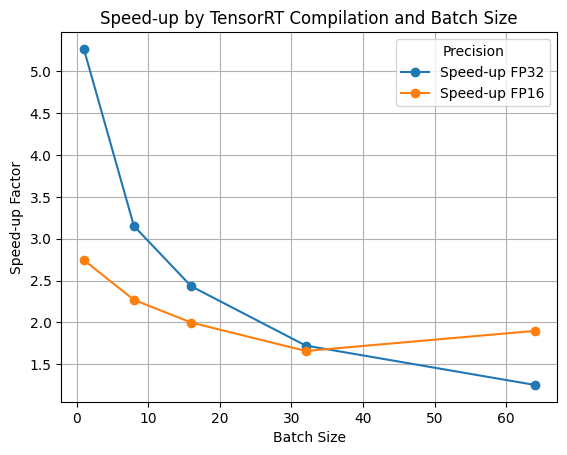

In [ ]:
#| eval: false
# Line Plot for Speed-up by Batch Size
for precision in speedup_df["Precision"].unique():
    subset = speedup_df[speedup_df["Precision"] == precision]
    plt.plot(subset["Batch Size"], subset["Speed-up"], marker='o', linestyle='-', label=f"Speed-up {precision}")

plt.title("Speed-up by TensorRT Compilation and Batch Size")
plt.ylabel("Speed-up Factor")
plt.xlabel("Batch Size")
plt.legend(title="Precision")
plt.grid(True)
plt.show()

## Acceleration with ONNX Runtime with TensorRT execution provider

https://pytorch.org/TensorRT/getting_started/installation.html
Building Natively on aarch64 (Jetson)

Test with inference using the validation dataset

In [ ]:
#| eval: false
import os
import random
import numpy as np
from PIL import Image
from pathlib import Path

Categories: n01440764, n02102040, n02979186, n03000684, n03028079, n03394916, n03417042, n03425413, n03445777, n03888257
Number of validation images: 3925
Image from category n03417042 (index 6): n03417042_5600.JPEG


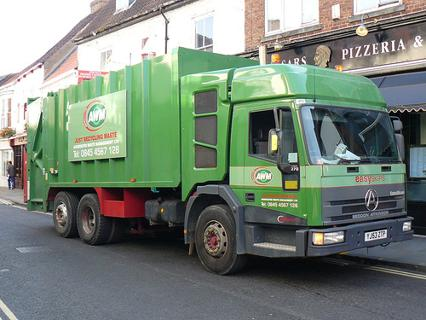

In [ ]:
#| eval: false
# Load the dataset and categories
dataset_path = Path.cwd() / 'data' / 'imagenette2-320'
categories = sorted(os.listdir(dataset_path / 'train'))
print(f"Categories: {', '.join(categories)}")

# Construct random samples from each category 
val_data = list((dataset_path / 'val').rglob('*.JPEG'))
print(f"Number of validation images: {len(val_data)}")

# Load a sample image
image_path = val_data[random.randint(0, len(val_data))]
print(f"Image from category {image_path.parent.name} (index {categories.index(image_path.parent.name)}): {image_path.name}")
Image.open(image_path)

In [ ]:
#| eval: false
def load_image(image_path, target_size=(224, 224)):
    """Load and preprocess the image."""
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image).astype(np.float32)

    # Normalize the image (ResNet-18 normalization mean and std values)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    image_array = (image_array / 255.0 - mean) / std

    # Reshape to (1, 3, 224, 224) as expected by the model
    image_array = np.transpose(image_array, (2, 0, 1))  # HWC -> CHW
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

image_array = load_image(image_path)
image_array.shape

(1, 3, 224, 224)

### ONNX

pip install "numpy<2"  
pip install onnxruntime

To test TensorRT acceleration, a PyTorch model is first converted to ONNX using `torch.onnx.export()`. TensorRT then optimizes the ONNX model for NVIDIA GPUs by applying techniques like layer fusion, precision reduction (FP16/INT8), and kernel tuning. The result is a highly efficient TensorRT engine for accelerated inference.

In [ ]:
#| eval: false
import torch.onnx

In [ ]:
#| eval: false
# Define a dummy input with the shape (1, 3, 224, 224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Move the dummy input to the same device as the model

# Define the path for the ONNX export
onnx_model_path = "models/resnet18_imagenette.onnx"  # Save to 'models' directory

# Export the model to ONNX format
model.eval()
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_model_path, 
    input_names=["input"], 
    output_names=["output"]
)

print(f"Original pre-trained model exported to {onnx_model_path}")

Original pre-trained model exported to models/resnet18_imagenette.onnx


#### ONNX runtime with TensorRT as execution context
[ONNX Runtime](https://onnxruntime.ai/) supports Python API for running inference from an .onnx model. It can also be accelerated by using TensorRT as its execution context. TensorRT has to be installed beforehand, and its path should be set with:

```sh
$ export LD_LIBRARY_PATH=/usr/lib/aarch64-linux-gnu:$LD_LIBRARY_PATH
```

Then, `onnxruntime_gpu` needs to be installed via a custom wheel provided by NVIDIA for Jetson devices. Follow this [link](https://pypi.jetson-ai-lab.dev/), select the JetPack and CUDA of your device, and download a suitable wheel depending on the Python version. For example, with JetPack 6+, CUDA 12.6, and Python=3.10, `onnxruntime_gpu==1.20.0` will be installed in this tutorial:

```sh
$ wget https://pypi.jetson-ai-lab.dev/jp6/cu126/+f/0c4/18beb3326027d/onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl#sha256=0c418beb3326027d83acc283372ae42ebe9df12f71c3a8c2e9743a4e323443a4
$ pip install onnxruntime_gpu-1.20.0-cp310-cp310-linux_aarch64.whl

```

Verify the installation with:

In [ ]:
#| eval: false
import onnxruntime as ort
print(ort.get_device())                 # Should print 'GPU' or 'CPU'
print(ort.get_available_providers())    # Should print 
# ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']

GPU
['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In this tutorial, construct multiple sessions ...

In [ ]:
#| eval: false
import time
import onnxruntime as ort
import numpy as np

In [ ]:
#| eval: false
def run_inference(session, image_array):
    """Run inference, apply softmax, and get the predicted class."""
    # Get input and output names
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    # Run inference
    logits = session.run([output_name], {input_name: image_array})[0]
    
    # Apply softmax to logits to get probabilities
    probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    
    # Get the predicted class
    predicted_class = np.argmax(probabilities)
    
    return predicted_class, probabilities

In [ ]:
#| eval: false
# Define the path to the exported ONNX model
onnx_model_path = "models/resnet18_imagenette.onnx"

# Construct multiple InferenceSession objects with different providers
cpu_session = ort.InferenceSession(onnx_model_path)
cuda_session = ort.InferenceSession(
    onnx_model_path, 
    providers=[
        ("CUDAExecutionProvider", {
            "device_id": 0,                                 # Use the first available GPU
            "arena_extend_strategy": "kNextPowerOfTwo",     # Efficient memory management
            "gpu_mem_limit": 2 * 1024 * 1024 * 1024,        # Limit memory usage (adjust for Jetson Nano)
            "cudnn_conv_algo_search": "EXHAUSTIVE",         # Optimize convolution algorithms
            "do_copy_in_default_stream": True,              # Reduce synchronization overhead
        })
    ]
)
trt_session = ort.InferenceSession(
    onnx_model_path, 
    providers=[
        ('TensorrtExecutionProvider', {
            'device_id': 0,                          # Select GPU to execute
            'trt_max_workspace_size': 2147483648,    # Set GPU memory usage limit (e.g., 2GB)
            'trt_fp16_enable': True,                 # Enable FP16 precision for faster inference
        }),
    ]
)

In [ ]:
#| eval: false
# Run inference with the CPU provider
start_time = time.time()
predicted_class, probabilities = run_inference(cpu_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 6
Inference Time: 0.06018710136413574 seconds
Class Probabilities: [[2.8983616e-10 6.2775657e-10 4.6363002e-07 2.1837502e-08 3.9283857e-10
  4.3800658e-10 9.9999607e-01 3.4335710e-06 5.4752858e-10 1.5945385e-09]]


In [ ]:
#| eval: false
# Note: If inference time is slow, try running this cell again
# because the first inference might involve additional setup time for CUDA
# Run inference with the CUDA provider
start_time = time.time()
predicted_class, probabilities = run_inference(cuda_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 6
Inference Time: 0.02844691276550293 seconds
Class Probabilities: [[2.9011216e-10 6.2827110e-10 4.6380845e-07 2.1848063e-08 3.9324449e-10
  4.3827234e-10 9.9999607e-01 3.4338229e-06 5.4782839e-10 1.5960537e-09]]


In [ ]:
#| eval: false
# Run inference with the TensorRT provider
start_time = time.time()
predicted_class, probabilities = run_inference(trt_session, image_array)
end_time = time.time()

print(f"Predicted Class: {predicted_class}")
print(f"Inference Time: {end_time - start_time} seconds")
print(f"Class Probabilities: {probabilities}")

Predicted Class: 6
Inference Time: 0.013691186904907227 seconds
Class Probabilities: [[2.9462538e-10 6.3354416e-10 4.6735542e-07 2.1986956e-08 3.9646181e-10
  4.4228510e-10 9.9999607e-01 3.4545803e-06 5.5474980e-10 1.6052217e-09]]


In [ ]:
#| eval: false
# Arrays to store inference times and accuracies for different sessions
session_names = ["CPU", "CUDA", "TensorRT"]
session_times = [[] for _ in session_names]
session_accs  = [[] for _ in session_names]

# Run inference on all images in the validation set
for image_path in val_data:
    try:
        image_array = load_image(image_path)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        raise e
    for i, session in enumerate([cpu_session, cuda_session, trt_session]):
        start_time = time.time()
        predicted_class, _ = run_inference(session, image_array)
        end_time = time.time()
        
        session_times[i].append(end_time - start_time)
        session_accs[i].append(predicted_class == categories.index(image_path.parent.name))

# Report inference time and accuracy for each session
for i, session_name in enumerate(session_names):
    total_time = np.sum(session_times[i])
    avg_accuracy = np.mean(session_accs[i])
    print(f"{session_name} - Total Inference Time: {total_time:.4f} seconds, Accuracy: {avg_accuracy:.4f}")

CPU - Total Inference Time: 180.5405 seconds, Accuracy: 0.9292
CUDA - Total Inference Time: 77.7771 seconds, Accuracy: 0.9289
TensorRT - Total Inference Time: 18.4968 seconds, Accuracy: 0.9292
